In [3]:
def __return_waypoints_ind():
    d = np.array([
    [ 65, -36],
    [ 56, -21],
    [ 66, -46],
    [ 58, -48],
    [ 67, -29],
    [ 61, -16],
    [ 45, -32],
    [ 71, -43],
    # [ 80, -52],
    # [ 68, -58],
    [ 65, -54],
    [ 48, -20],
    [ 64, -21],
    [ 46, -14]])
    return d


def __return_waypoints_sdd():
    d = np.array([[24, 34],
       [16, 35],
       [24, 20],
       [14, 20],
       [14, 11],
       [ 6, 33],
       [ 7, 47],
       [23, 48]])
    return d


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os, sys
from helpers.highlevel_sceneloader import HighLevelSceneLoader
from predictors.dataset_creator import TFDataSet
import tensorflow as tf
from predictors.dl_trainer import DLTrainer 
from predictors.extended_predictor import extended_predictor 
import matplotlib.pyplot as plt
import pickle
from helpers.graph import Graph
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


''' set some parameters '''
# Model parameters
LSTM_LAYER_SIZE = 32
DENSE_LAYER_SIZE = 32
NUM_LSTM_LAYERS = 2
NUM_DENSE_LAYERS = 2
VARIABLE_INPUT_LENGTH = False

# Dataset
SEQ_IN_LEN = 3
SEQ_OUT_LEN = 4
NOISE_STD = .1
N_REPEATS = 1

BATCH_SIZE = 5
LENGTH_STRIDE = 2


# Training parameters
MAX_EPOCHS = 100
PATIENCE = 10

# For graph
GRAPH_DIST_THRESH = 4

''' get the data '''
ROOT = os.getcwd()

rel_p_img_b = 'helpers/analysed_vars_storage/img_bounds.xml'
rel_p_dests = 'helpers/analysed_vars_storage/destination_locations.xml'
p_img_bounds = os.path.join(ROOT, rel_p_img_b)
p_dest_locs = os.path.join(ROOT, rel_p_dests)

#TODO: older version of OpenTraj needed: "git checkout d249ba6951dd0f54b532fbe2ca6edc46b0d7093f"
opentraj_root = os.path.join(ROOT, 'OpenTraj')
root_datasets = os.path.join(ROOT, 'data/path_data')
sys.path.append(opentraj_root) # add package to pythonpath

scene_data = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
# scene_data.load_ind(root_datasets, 7, 17)
scene_data.load_sdd(opentraj_root, "little", "video3")

#BREAKING PATHS
scene_data.break_up_paths(12)

''' create the graph instance '''    
# interest_points = __return_waypoints_ind()
interest_points = __return_waypoints_sdd()
g = Graph.from_matrices(interest_points, scene_data.destination_matrix, GRAPH_DIST_THRESH, .05)

df_signals = scene_data.df_to_lst_realxy_mats()
g.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)
g.recalculate_trans_mat_dependencies()


<Element 'dataset' at 0x7fea08e1df40>
<Element 'dataset' at 0x7fea08e2a630>


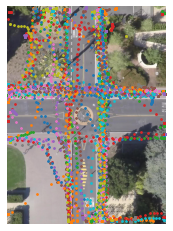

In [25]:
scene_data.plot_all_trajs_on_img('data/images/hello.png')

In [21]:
scene_data.num_trajectories

277

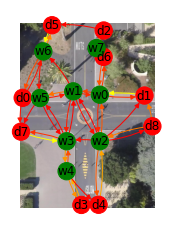

In [6]:
my_graph = g.create_graph(.05)
g.visualize_graph(my_graph, "data/images/new_scene/graph.png", scene_loader=scene_data)

In [5]:

''' time to create df datasets '''
extra_features_dict = {
    "all_points": None,
    "all_destinations": None,
    "n_destinations": 5,
    "n_points": 5,
    "n_connected_points_after" : 3
}

# # Load data in order to not need to do calculations again
with open("data/pickle/ds_creation_d/sdd_little_3.pickle", 'rb') as handle: #"data/pickle/ds_creation_d/bs1.pickle"
    my_ds_creation_dict = pickle.load(handle)

my_ds = TFDataSet.init_as_fixed_length(scene_data.traj_dataframe, graph=g, var_in_len=VARIABLE_INPUT_LENGTH, length_stride=LENGTH_STRIDE,
scale_list=["pos_x", "pos_y"], seq_in_length=SEQ_IN_LEN, label_length=SEQ_OUT_LEN,
extra_features_dict=extra_features_dict, noise_std=NOISE_STD, 
n_repeats=N_REPEATS, batch_size=BATCH_SIZE, ds_creation_dict=my_ds_creation_dict ) #  save_folder = "data/pickle/ds_creation_d/sdd_little_3.pickle"


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [6]:
for el in iter(my_ds_creation_dict["train"]):
    print(el["input_labels"].shape)
    print(el.keys())
    print(el)
    break

(23, 108, 2)
dict_keys(['xy', 'labels', 'input_labels', 'all_points', 'all_destinations', 'n_destinations', 'n_points', 'n_connected_points_after'])
{'xy': <tf.Tensor: shape=(23, 7, 2), dtype=float32, numpy=
array([[[ 1.127517  ,  0.17181538],
        [ 0.9971023 ,  0.19980611],
        [ 0.86668766,  0.23304509],
        [ 0.7417641 ,  0.2680335 ],
        [ 0.61821336,  0.3030219 ],
        [ 0.51937276,  0.37124932],
        [ 0.4493607 ,  0.4552215 ]],

       [[ 0.9971023 ,  0.19980611],
        [ 0.86668766,  0.23304509],
        [ 0.7417641 ,  0.2680335 ],
        [ 0.61821336,  0.3030219 ],
        [ 0.51937276,  0.37124932],
        [ 0.4493607 ,  0.4552215 ],
        [ 0.38483974,  0.53394544]],

       [[ 0.86668766,  0.23304509],
        [ 0.7417641 ,  0.2680335 ],
        [ 0.61821336,  0.3030219 ],
        [ 0.51937276,  0.37124932],
        [ 0.4493607 ,  0.4552215 ],
        [ 0.38483974,  0.53394544],
        [ 0.32443717,  0.6109199 ]],

       [[ 0.7417641 ,  0.26803

In [7]:
# # ''' time for some model training '''

# my_trainer = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
# my_trainer.LSTM_one_shot_predictor_named_i(my_ds, LSTM_LAYER_SIZE, DENSE_LAYER_SIZE, 
# NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=["all_destinations"], 
# var_time_len=VARIABLE_INPUT_LENGTH, size_dict=my_ds.size_dict)

# from datetime import datetime 

# folder_path = "data/model_weights/checkpoints/%s" % (datetime.now().strftime("%d_%m_%Y__%H_%M"))
# save_path = os.path.join(folder_path, "model_sdd_3_4.pickle")            
# if not os.path.exists(folder_path):
#     os.mkdir(folder_path)
# my_trainer.compile_and_fit2(my_ds.tf_ds_dict["train"], my_ds.tf_ds_dict["val"], save_path=save_path)

3
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 2), dtype=tf.float32, name='in_xy'), name='in_xy', description="created by layer 'in_xy'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 3), dtype=tf.float32, name='all_destinations'), name='all_destinations', description="created by layer 'all_destinations'")
Epoch 1/100
451/451 [==============================] - 12s 13ms/step - loss: 0.2112 - mean_absolute_error: 0.2971 - val_loss: 0.0667 - val_mean_absolute_error: 0.2026

Epoch 00001: val_loss improved from inf to 0.06673, saving model to data/model_weights/checkpoints/14_09_2021__23_17/model_sdd_3_4.pickle
Alternative save happened on for epoch 0 happened on data/model_weights/checkpoints/14_09_2021__23_17/model_sdd_3_4.pickle for val_loss of 0.0667.
Epoch 2/100
451/451 [==============================] - 3s 6ms/step - loss: 0.0511 -

In [37]:
''' or some model loading '''

model_path = "data/model_weights/checkpoints/07_09_2021__23_15/model_sdd_3_4.pickle"

my_trainer = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
my_trainer.LSTM_one_shot_predictor_named_i(my_ds, 32, 32, 
NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=["all_destinations"], 
var_time_len=VARIABLE_INPUT_LENGTH, size_dict=my_ds.size_dict, epistemic=True, dropout_rate=0.05)
my_trainer.load_weights(model_path)

3
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 2), dtype=tf.float32, name='in_xy'), name='in_xy', description="created by layer 'in_xy'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='flatten_2/Reshape:0', description="created by layer 'flatten_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 3), dtype=tf.float32, name='all_destinations'), name='all_destinations', description="created by layer 'all_destinations'")


In [38]:
''' time for some model predictions '''
my_predictor = extended_predictor(g, my_trainer, 1)

nxt_unsc, nxt_sc = my_ds.example_dict("test", "in_xy")

# Let's extract just one path to make visualisation clearer
unscaled_ex = dict(nxt_unsc[0]), nxt_unsc[1]
scaled_ex = dict(nxt_sc[0]), nxt_sc[1]
# let's get an example of length one
for key in unscaled_ex[0].keys():
    unscaled_ex[0][key] = tf.expand_dims(nxt_unsc[0][key][0], axis=0)
for key in scaled_ex[0].keys():
    scaled_ex[0][key] = tf.expand_dims(nxt_sc[0][key][0], axis=0)   

In [39]:
# Basic prediction, but repeated (one at a time)
#PROBLEM: input is scaled
assembled_output, destination_list, dest_prob_dict = my_predictor.predict_to_destinations(input_dict=unscaled_ex[0], 
num_steps = 20, variable_len_input=VARIABLE_INPUT_LENGTH, num_predictions=15, norm_probs=True, abs_probs=False)
# Epistemic uncertainty prediction


In [12]:
assembled_output[1]

<tf.Tensor: shape=(15, 20, 2), dtype=float32, numpy=
array([[[23.487774, 54.37043 ],
        [24.857212, 54.252174],
        [26.169298, 54.216213],
        [27.673386, 54.16519 ],
        [28.77798 , 52.53714 ],
        [30.726574, 52.394104],
        [32.526314, 52.321243],
        [34.337635, 52.243637],
        [35.751656, 49.431614],
        [37.908455, 49.81224 ],
        [39.712257, 50.208   ],
        [41.572006, 50.57734 ],
        [41.544304, 46.783157],
        [43.71707 , 47.61927 ],
        [45.317898, 48.51469 ],
        [47.143112, 49.29077 ],
        [45.18502 , 44.564514],
        [47.43076 , 45.441536],
        [48.982628, 46.493828],
        [50.808716, 47.337463]],

       [[23.487774, 54.37043 ],
        [24.857212, 54.252174],
        [26.169298, 54.216213],
        [27.673386, 54.16519 ],
        [28.77798 , 52.53714 ],
        [30.726574, 52.394104],
        [32.526314, 52.321243],
        [34.337635, 52.243637],
        [35.751656, 49.431614],
        [37.90845

Grid sum is 1.0
Grid sum is 1.0
Grid sum is 1.0
Grid sum is 1.0000001
Grid sum is 1.0000001
Grid sum is 1.0
Grid sum is 1.0
Grid sum is 1.0
Grid sum is 1.0
Grid sum is 1.0
Grid sum is 1.0


KeyboardInterrupt: 

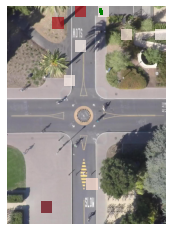

In [15]:
scene_data.plot_aggregated_probs_progress(assembled_output[:,:,:,:], dest_prob_dict, grid_resolution=3, invert_y=True,
disable_axes=True, alpha_val = .7, min_steps = 0, max_steps = 20, lst_real_xy_mats=[scaled_ex[0]["input_labels"]],
)

Prediction with coordinates (tf.Tensor(14.85236, shape=(), dtype=float32), tf.Tensor(-2.4662628, shape=(), dtype=float32)) out of the grid. (4,-1) for a grid size of (14,19)
Prediction with coordinates (tf.Tensor(14.654789, shape=(), dtype=float32), tf.Tensor(-2.847187, shape=(), dtype=float32)) out of the grid. (4,-1) for a grid size of (14,19)
Prediction with coordinates (tf.Tensor(13.85096, shape=(), dtype=float32), tf.Tensor(-3.694046, shape=(), dtype=float32)) out of the grid. (4,-2) for a grid size of (14,19)
Prediction with coordinates (tf.Tensor(12.875847, shape=(), dtype=float32), tf.Tensor(-4.333153, shape=(), dtype=float32)) out of the grid. (4,-2) for a grid size of (14,19)
Prediction with coordinates (tf.Tensor(12.542252, shape=(), dtype=float32), tf.Tensor(-4.495411, shape=(), dtype=float32)) out of the grid. (4,-2) for a grid size of (14,19)
Prediction with coordinates (tf.Tensor(18.818312, shape=(), dtype=float32), tf.Tensor(-2.5943832, shape=(), dtype=float32)) out of 

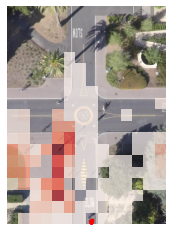

In [48]:
scene_data.plot_aggregated_output_probs(assembled_output[:,:,15:20,:], dest_prob_dict, grid_resolution=3, invert_y=True,
disable_axes=True, alpha_val = .7, lst_real_xy_mats=[scaled_ex[0]["input_labels"]], save_path="all_no_epi.png")

In [31]:
scaled_ex[0].keys()

dict_keys(['labels', 'input_labels', 'all_points', 'all_destinations', 'n_destinations', 'n_points', 'n_connected_points_after', 'in_xy'])

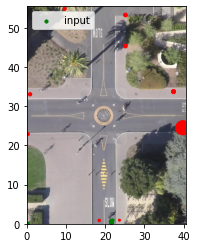

In [49]:
i=0
fig1, ax = plt.subplots()
scene_data.plot_on_image([scaled_ex[0]["input_labels"][i]], 
save_path='data/images/final_notebook/example_prediction.png', ms = [10, 6], ax=ax, colors=["green", "blue"],
col_num_dicts=[my_ds.generalised_out_dict], labels=["input"], image_provided=False)

dest_locs = scaled_ex[0]["all_destinations"][i][:, 0:2]
dest_probs = scaled_ex[0]["all_destinations"][i][:, 2:3]

scene_data.plot_dest_probs(dest_locs, dest_probs, 2, 200,
ax = ax)

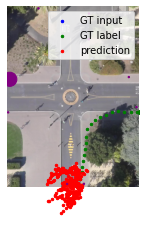

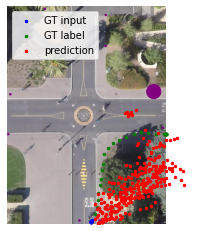

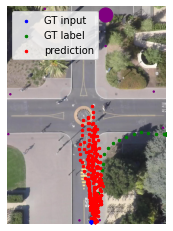

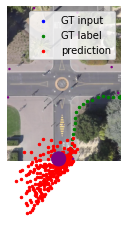

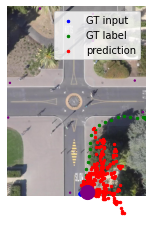

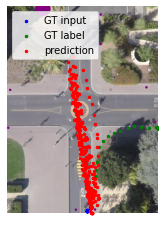

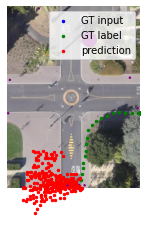

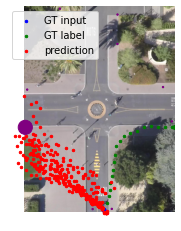

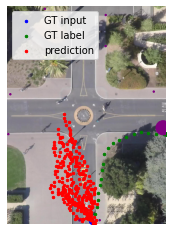

In [50]:
# # PLOT BASIC PREDICTION
# # create dicts for correctly displaying data    

# input_number = 4

# unscaled_ex_ = dict(nxt_unsc[0]), nxt_unsc[1][input_number]
# # let's get an example of length one
# for key in unscaled_ex_[0].keys():
#     unscaled_ex_[0][key] = tf.expand_dims(unscaled_ex_[0][key][input_number], axis=0)

# assembled_output, destination_list, dest_prob_dict = my_predictor.predict_to_destinations(unscaled_ex_[0], 11, 1, VARIABLE_INPUT_LENGTH)

for i in range(9):
    fig1, ax1 = plt.subplots()

    scene_data.plot_on_image([unscaled_ex[0]["input_labels"], unscaled_ex[0]["labels"], assembled_output[i]], 
    save_path='data/images/final_notebook/example_prediction.png', ms = [6, 6, 6], ax=ax1, colors = ['blue', 'green', 'red'],
    col_num_dicts=[my_ds.generalised_in_dict, my_ds.generalised_out_dict,my_ds.generalised_out_dict], labels=["GT input", "GT label", "prediction"],
    hide_axes=True)
    
    dest_locs = destination_list[i][:, :, 0:2]
    dest_probs = destination_list[i][:, :, 2:3]
    
    scene_data.plot_dest_probs(dest_locs[0], dest_probs[0], 2, 200,
    ax = ax1, save_path = "data/images/adjusted_dest/"+str(i)+".png", color="purple")

In [73]:
unscaled_ex[0].keys()

dict_keys(['labels', 'input_labels', 'all_points', 'all_destinations', 'n_destinations', 'n_points', 'n_connected_points_after', 'in_xy'])

In [93]:
ass_out_resh

<tf.Tensor: shape=(300, 2), dtype=float32, numpy=
array([[ 53.091095 ,  -9.982044 ],
       [ 54.48001  , -11.0906315],
       [ 55.299946 , -12.028469 ],
       [ 56.22097  , -12.937012 ],
       [ 57.484932 , -15.21657  ],
       [ 58.60121  , -16.68612  ],
       [ 59.266464 , -18.085411 ],
       [ 59.941303 , -19.45072  ],
       [ 61.43778  , -21.030033 ],
       [ 62.130108 , -23.077606 ],
       [ 62.661655 , -25.044619 ],
       [ 63.14069  , -26.849463 ],
       [ 63.95107  , -29.539701 ],
       [ 64.35668  , -32.083256 ],
       [ 64.82704  , -34.545628 ],
       [ 65.1679   , -36.836586 ],
       [ 65.94622  , -39.38974  ],
       [ 66.97158  , -42.13425  ],
       [ 68.26199  , -44.818462 ],
       [ 69.394806 , -47.33781  ],
       [ 53.847614 , -14.443275 ],
       [ 55.000122 , -15.686157 ],
       [ 55.756195 , -16.719492 ],
       [ 56.481857 , -17.738192 ],
       [ 57.61752  , -20.978481 ],
       [ 58.902878 , -21.78109  ],
       [ 59.7766   , -22.548824 ],
     

In [101]:
remove_padding_vals(scaled_ex[0]["input_labels"][0])

<tf.Tensor: shape=(21, 2), dtype=float32, numpy=
array([[ 36.52051,  -4.2329 ],
       [ 39.68891,  -8.237  ],
       [ 43.17372, -10.96981],
       [ 45.87157, -11.25375],
       [ 47.03464, -10.47621],
       [ 48.41434,  -9.9802 ],
       [ 49.10177,  -9.87653],
       [ 49.09309,  -9.80739],
       [ 48.88221,  -9.80213],
       [ 48.80585,  -9.86365],
       [ 48.77809, -10.00952],
       [ 48.82646,  -9.97876],
       [ 48.85715,  -9.9729 ],
       [ 48.84065,  -9.96946],
       [ 48.81809,  -9.98864],
       [ 48.80229,  -9.97806],
       [ 48.9215 , -10.08755],
       [ 48.97831, -10.12655],
       [ 48.78694,  -9.87245],
       [ 49.52075,  -9.35103],
       [ 51.47932,  -9.53124]], dtype=float32)>

In [ ]:
dest_id = 6
ass_out_resh = tf.reshape(assembled_output[dest_id,:,:,:], (-1, 2))
from helpers.accuracy_functions import remove_padding_vals

fig1, ax = plt.subplots()
scene_data.plot_on_image([remove_padding_vals(scaled_ex[0]["input_labels"][0]), ass_out_resh], 
save_path='data/images/final_notebook/example_prediction__4.png', ms = [10, 2], ax=ax, colors=["green", "blue"],
col_num_dicts=[my_ds.generalised_out_dict], labels=["input", "output"], image_provided=False, hide_axes=True,
title="Predictions using premanent dropout for epistemic \n uncertainty representation")

Error: Kernel is dead

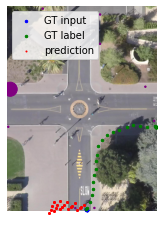

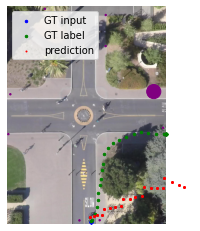

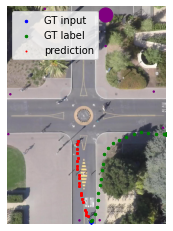

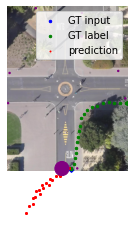

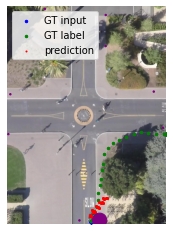

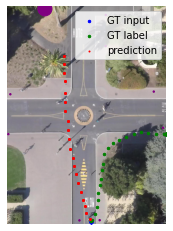

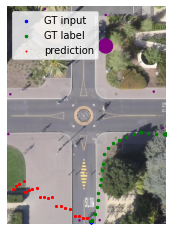

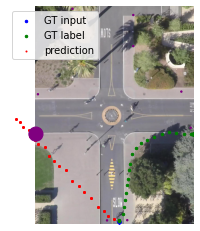

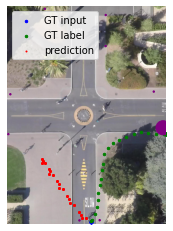

In [34]:
# Plot the epistemic stuff for each destination
from helpers.accuracy_functions import remove_padding_vals

for i in range(9):
    fig1, ax1 = plt.subplots()
    ass_out_resh = tf.reshape(assembled_output[i,:,:,:], (-1, 2))
    scene_data.plot_on_image([remove_padding_vals(scaled_ex[0]["input_labels"][0]), remove_padding_vals(scaled_ex[0]["labels"][0]), ass_out_resh], 
    save_path='data/images/final_notebook/example_prediction_'+str(i)+'.png', ms = [6, 6, 1], ax=ax1, colors = ['blue', 'green', 'red'],
    col_num_dicts=[my_ds.generalised_in_dict, my_ds.generalised_out_dict,my_ds.generalised_out_dict], labels=["GT input", "GT label", "prediction"],
    hide_axes=True)
    
    dest_locs = destination_list[i][:, :, 0:2]
    dest_probs = destination_list[i][:, :, 2:3]
    
    scene_data.plot_dest_probs(dest_locs[0], dest_probs[0], 2, 200,
    ax = ax1, save_path = "data/images/adjusted_dest/"+str(i)+".png", color="purple")